<a href="https://colab.research.google.com/github/afshari-maryam/NLP-knowledgeGraph/blob/main/Knowledge_Graph_%26_NLP_Tutorial_(BERT%2CspaCy%2CNLTK).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Knowledge Graph

**Import Dependencies & Load dataset**

In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/content/drive/MyDrive/inputs/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [4]:
candidate_sentences['sentence'].sample(5)

2390                                                                                                                the travancore national pictures was the first film studio in kerala.
3570                                                                                                                 the film was produced by robert lorenz, judie g. hoyt, and eastwood.
3495                                                                                                                                                 china does not have a rating system.
2388    the national award-winning music composers of malayalam cinema are johnson , bombay ravi , ouseppachan , ilaiyaraaja , issac thomas kottukapally , bijibal  and m. jayachandran .
866                                                                                                                           lori pelenise tuisano portrays sefina hobbs, luke's mother.
Name: sentence, dtype: object

**Sentence Segmentation**

In [5]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... amod
standard ... compound
d823 ... pobj


**Entities Extraction**

We can easily do this with the help of parts of speech (POS) tags.

We need to parse the dependency tree of the sentence.

To build a knowledge graph, the most important things are the nodes and the edges between them.


**Chunk 1**

Defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

**Chunk 2**

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

**Chunk 3**

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

**Chunk 4**

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

**Chunk 5**

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

In [6]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [7]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [8]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:29<00:00, 146.88it/s]


In [9]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'existing music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'selene gallio'],
 ['singer', 'sequel']]

**Relations Extraction**

Entity extraction is half the job done. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

Our hypothesis is that the predicate is actually the main verb in a sentence.

For example, in the sentence – “**Sixty Hollywood musicals were released in 1929**”, the verb is “released in” and this is what we are going to use as the predicate for the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching:

In [22]:
from spacy.matcher import Matcher
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  #matcher.add("matching_1", None, pattern)
  #matcher.add("matching_1", pattern, on_match = my_callback_function) 
  matcher = Matcher(nlp.vocab)
  matcher.add("matching_1", [pattern])

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

I encountered with a problem:
https://stackoverflow.com/questions/70321680/typeerror-add-takes-exactly-2-positional-arguments-3-given

In [ ]:
#from spacy.matcher import Matcher

#matcher = Matcher(nlp.vocab)
#matcher.add("matching_1", [pattern])
#matches = matcher(doc)

The **pattern** defined in the function tries to find the **ROOT word** or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word. Let me show you a glimpse of this function:

In [23]:
get_relation("John completed the task")

'completed'

In [24]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:25<00:00, 166.54it/s]


In [25]:
pd.Series(relations).value_counts()[:50]

is               364
was              299
released on       88
include           72
are               70
were              65
released          41
's                37
composed by       32
became            31
have              31
has               30
become            28
released in       27
included          23
called            21
produced          21
had               20
made              20
been              20
considered        20
be                18
used              18
scheduled         17
directed by       16
stars             16
received          15
wrote             14
hired             14
produced by       14
written by        13
introduced in     13
went              13
wanted            12
won               11
began             11
set               11
began in          11
includes          10
gave              10
directed          10
sold              10
gives              9
shot in            9
opened             9
cast as            9
known as           9
features     

**Build Knowledge Graph**

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [26]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

Next, we will use the **networkx library** to create a network from this **dataframe**. The nodes will represent **the entities and the edges** or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another.

In [27]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Let’s plot the network:

In [28]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

AttributeError: ignored

<Figure size 864x864 with 0 Axes>

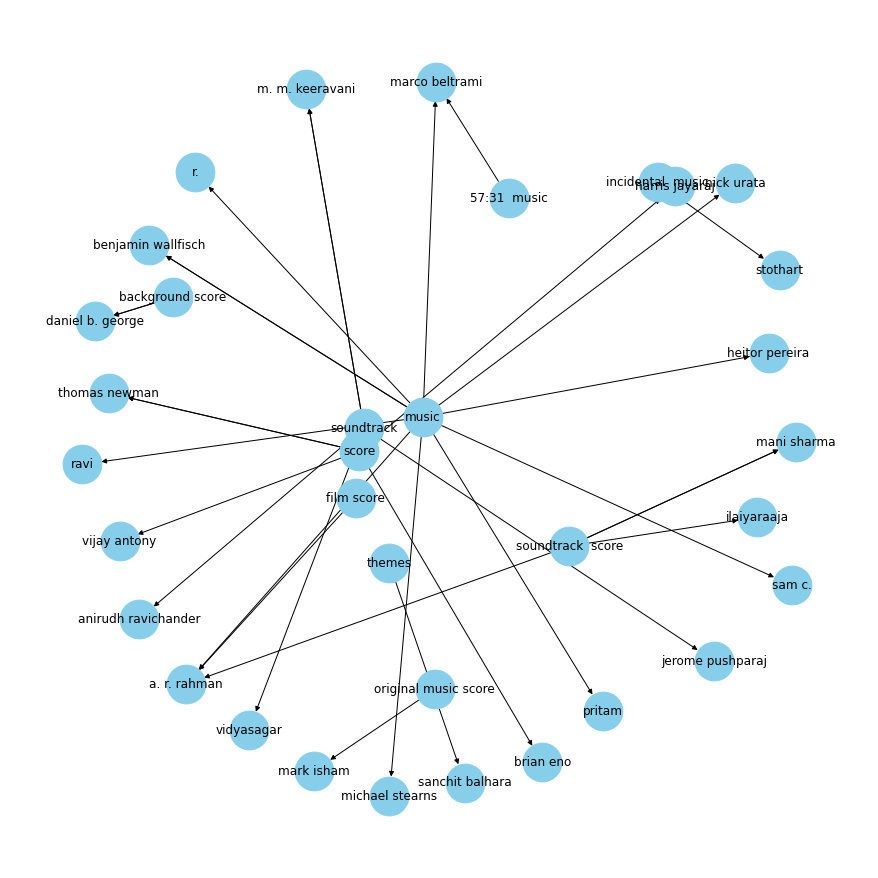

In [29]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph. Here the arrows point towards the composers. For instance, A.R. Rahman, who is a renowned music composer, has entities like “soundtrack score”, “film score”, and “music” connected to him in the graph above.

Let’s check out a few more relations.

Now I would like to visualize the graph for the “written by” relation:

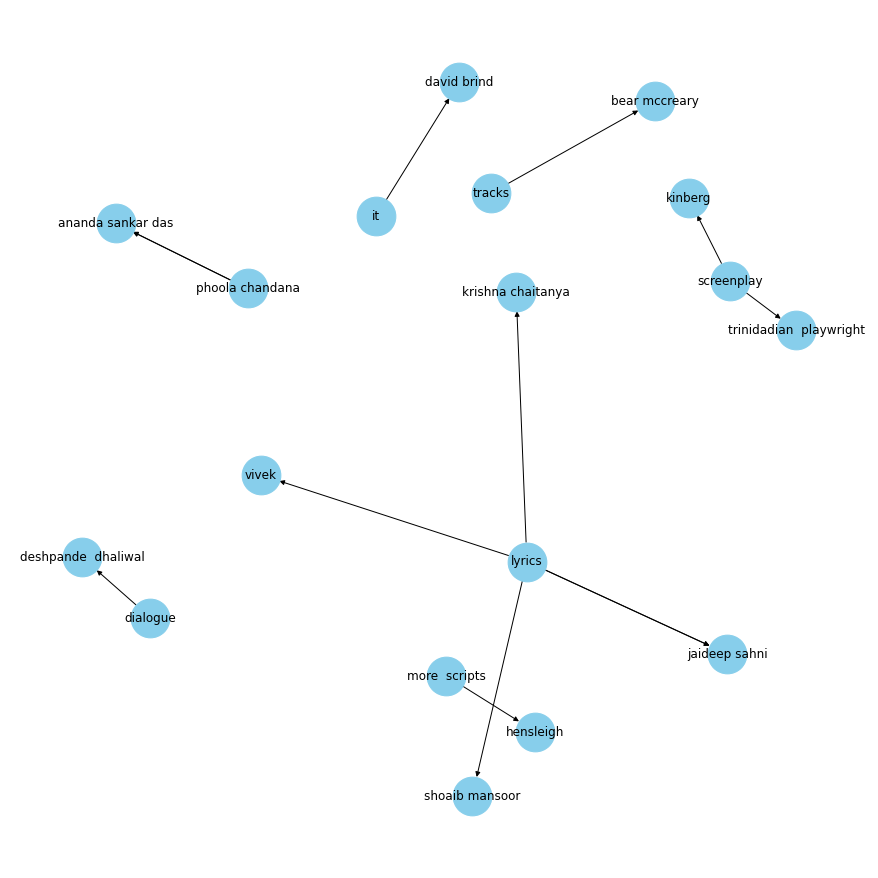

In [30]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

This knowledge graph is giving us some extraordinary information. Guys like Javed Akhtar, Krishna Chaitanya, and Jaideep Sahni are all famous lyricists and this graph beautifully captures this relationship.

Let’s see the knowledge graph of another important predicate, i.e., the “released in”:

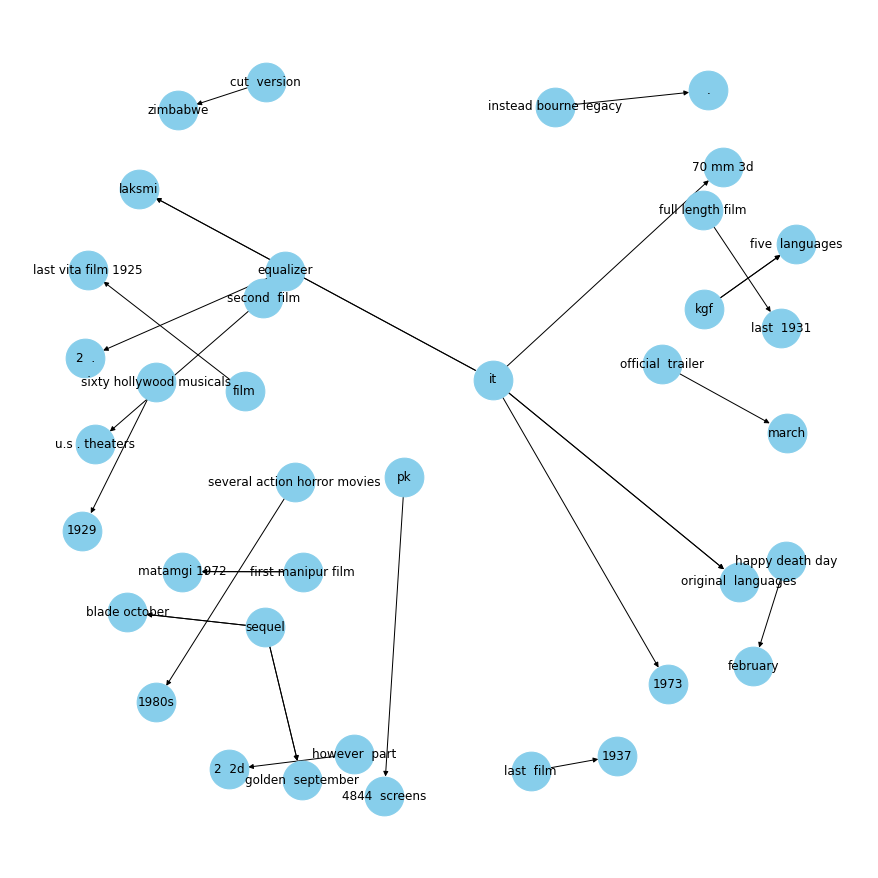

In [31]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#BERT: Bidirectional Encoder Representations from Transformers